In [1]:
import matplotlib.pyplot as plt
import numpy as np

from pixell import enmap
from pixell.curvedsky import map2alm, alm2cl, alm2map, rand_alm, rand_map, almxfl

from scipy.signal import savgol_filter

import time

LMAX=12000
R_LWIDTH=0.62
NTRIAL_NL = 1
NTRIAL_FL = 1
NITER_FL = 20

data_path = '/home/aroman/data/'
planck_path = data_path + 'planck/'
mask_path = data_path + 'mask/'

act_path = data_path + 'act/'
map_path = act_path + 'act_planck_s08_s19_cmb_f150_daynight_srcfree_map.fits'
ivar_path = act_path + 'act_planck_s08_s19_cmb_f150_daynight_srcfree_ivar.fits'
beam_path = act_path + 'beam_f150_daynight.txt'


# act_path = data_path + 'act_pub/'
# map_path = act_path + 'act_planck_dr5.01_s08s18_AA_f150_daynight_map_srcfree.fits'
# ivar_path = act_path + 'act_planck_dr5.01_s08s18_AA_f150_daynight_ivar.fits'
# beam_path = act_path + 'act_planck_dr5.01_s08s18_f150_daynight_beam.txt'

gal_mask_path = data_path + 'sdss_footprint/pixellized_sdss_north_completeness.fits'

planck_mask_inpath = planck_path + 'HFI_Mask_GalPlane-apo0_2048_R2.00.fits'
planck_enmask_path = mask_path + 'planck_foreground.npy'

catalog_path = data_path + 'vr_summaries/v01_sdss_cmass_north.h5'

kszpipe_path = data_path + 'kszpipe/sdss_dr12/cmass_north/'
kszpipe_cosmo_path = kszpipe_path + 'cosmology.pkl'
kszpipe_box_path = kszpipe_path + 'bounding_box.pkl'
kszpipe_d0_path = kszpipe_path + 'delta0_DR12v5_CMASS_North.h5'

def map2cl(map_t, lmax=LMAX):
    return alm2cl(map2alm(map_t, lmax=lmax))

# ref_map = enmap.read_map(map_path)[0]

ells = np.arange(LMAX + 1)
norm = ells * (1 + ells) / 2 / np.pi

ells_div = ells.copy()
ells_div[0] = 1.

ells_inv = 1./ells_div
ells_inv[0] = 0. # zero the first element

cl_invar = ells_inv**2
# cl_invar = np.ones(1 + LMAX)

# test the map2cl function
# rmap = rand_map(ref_map.shape, ref_map.wcs, cl_invar)
# cl_from_map = map2cl(rmap)

# plt.figure(dpi=300)
# plt.title('input cl vs map2cl')
# plt.plot(ells, cl_from_map, label='rand_map -> map2cl')
# plt.plot(ells, cl_invar, label='input cl')
# plt.legend()
# plt.show()


# plt.figure(dpi=300)
# plt.title('map2cl transfer function')
# plt.plot(ells, cl_from_map/cl_invar)
# plt.show()


def div_nozero(ar):
    zero_mask = ar == 0
    ret = ar.copy()
    ret[zero_mask] = 1.
    ret = 1./ret
    ret[zero_mask] = 0.
    return ret


def clean_cl(cl, lcut=50, fill_val=0.):
    ret = cl.copy()
    ret[:lcut] = fill_val
    return ret


def smooth_fl(fl):
    ret = savgol_filter(fl, 500, 2)
    return ret

 
class ACTData:
    def __init__(self, map_t, ivar_t, map_fkp,
                 lmax=LMAX, ntrial_nl=NTRIAL_NL, ntrial_fl=NTRIAL_FL, niter_fl=NITER_FL):
        self.map_t = map_t
        self.ivar_t = ivar_t
        self.std_t = np.sqrt(div_nozero(self.ivar_t))
        
        self.map_fkp = map_fkp
#         self.gal_mask = gal_mask
        
        self.lmax = lmax
        self.ntrial_fl = ntrial_fl
        self.niter_fl = niter_fl
        self.ntrial_nl = ntrial_nl
        
        self.ells = np.arange(1 + self.lmax)
        self.norm = self.ells * (1 + self.ells) / 2 / np.pi
        
        self.fl = None
        self.nl = None
    
    def get_noise_map(self):
        return enmap.ndmap(np.random.normal(size=self.map_t.shape) * self.std_t, self.map_t.wcs)            

    def get_rmap_cl(self, *, cl_ref=None, ntrial=1):
        if cl_ref is None:
            cl_ref = self.cl_act_sim
        
        print('making random map cl realization')
        cl = np.zeros(1 + self.lmax)
        for itrial in range(ntrial_fl):
            print(f'\t doing trial {itrial + 1} of {ntrial_fl}')
            rmap = rand_map(self.map_t.shape, self.map_t.wcs, cl_ref)
            cl_res = map2cl(rmap * self.map_fkp, self.lmax)
            cl += cl_res
        cl /= ntrial
        return cl
    
    def get_xfer(self, cl_ref=None, ntrial_fl=None):
        if cl_ref is None:
            cl_ref = np.ones(1 + self.lmax)
        
        if ntrial_fl is None:
            ntrial_fl = self.ntrial_fl
        
        print('making xfer function')
        fl = np.zeros(1 + self.lmax)
        for itrial in range(ntrial_fl):
            print(f'\t doing trial {itrial + 1} of {ntrial_fl}')
            rmap = rand_map(self.map_t.shape, self.map_t.wcs, cl_ref)
            cl_res = map2cl(rmap * self.map_fkp, self.lmax)
            fl += cl_res/cl_ref
        fl /= ntrial_fl
        return fl
    
    def make_xfer(self):
        # make noise power spectrum estimate
        nl = np.zeros(self.lmax + 1)
        
        print('making noise power estimate')
        for itrial in range(self.ntrial_nl):
            print(f'\t doing trial {itrial + 1} of {self.ntrial_nl}')
            rmap = self.get_noise_map()
            this_nl = map2cl(rmap * self.map_fkp, self.lmax)
            nl += this_nl
        self.nl = nl/self.ntrial_nl

        # generate act cl estimate with knowledge of nl and fl
        self.cl_act_obs = map2cl(self.map_t * self.map_fkp, self.lmax)
        
        fl = self.get_xfer() # start with a flat power spectrum (default)
        cl_act_sim = (self.cl_act_obs - self.nl) / fl
        
        if self.niter_fl > 1:
            iters = self.niter_fl - 1
            for itrial in range(iters):
                print(f'doing iterative fl trial {itrial + 2}')
                fl = self.get_xfer(cl_ref=cl_act_sim)
                cl_act_sim = (self.cl_act_obs - self.nl) / fl
        
        # assign the iteratively determined act power spectrum
        self.fl_raw = fl
#         self.fl = fl
        self.fl = smooth_fl(fl)
        self.cl_act_sim = cl_act_sim
    
    def get_rand_map(self):
        ret = rand_map(self.map_t.shape, self.map_t.wcs, self.cl_act_sim)
        return ret
    
    # generate a random map realization from two separate
    def get_rand_maps_lcut(self, lcut=2000):
        assert lcut > 1
        assert lcut < self.lmax
        left_ells = np.arange(lcut)
        right_ells = np.arange(lcut, self.lmax + 1, 1)
        
        left_cl = self.cl_act_sim.copy()
        left_cl[right_ells] = 0.
        right_cl = self.cl_act_sim.copy()
        right_cl[left_ells] = 0.
        
        left_map = rand_map(self.map_t.shape, self.map_t.wcs, left_cl)
        right_map = rand_map(self.map_t.shape, self.map_t.wcs, right_cl)
        return left_map, right_map
    
    def get_empty_map(self):
        return enmap.empty(self.map_t.shape, self.map_t.wcs)

    def get_zero_map(self):
        return enmap.ndmap(np.zeros(self.map_t.shape), self.map_t.wcs)
    
    def get_sim_map(self):
        return self.get_rand_map() + self.get_noise_map()
    
    # Return a map processed according to the new 2D paradigm
    # T_obs -> mask_fkp ---sph---> l_weight ---sph_inv---> mask_sdss -> fin
    #
    def process_map(self, sdss_mask, l_weight=None, map_t=None):
        if map_t is None:
            map_t = self.map_t
            
        if l_weight is None:
            l_weight = np.zeros(1 + self.lmax) + 1.
        
        fkp_map = map_t * self.map_fkp
        t_alm = map2alm(fkp_map, lmax=self.lmax)
        t_map = alm2map(almxfl(t_alm, l_weight), self.get_zero_map())
        
        return t_map * sdss_mask
    
    def compare_cl(self, label=''):
        rmap = self.get_rand_map()
        rmap += self.get_noise_map()
        rmap_cl = map2cl(rmap * self.map_fkp, self.lmax)
        
        lomap, himap = self.get_rand_maps_lcut()
        lo_cl = map2cl(lomap * self.map_fkp, self.lmax)
        hi_cl = map2cl(himap * self.map_fkp, self.lmax)
        noise_cl_obs = map2cl(self.get_noise_map() * self.map_fkp, self.lmax)
        
        plt.figure(dpi=300)
        plt.title(label + ' observed vs sim cl')
        plt.plot(self.ells, self.norm * clean_cl(self.cl_act_obs), label='observed act cl', linewidth=1)
#         plt.plot(self.ells, self.norm * clean_cl(self.cl_act_obs - self.nl), label='observed act cl (noiseless)')
        plt.plot(self.ells, self.norm * clean_cl(rmap_cl), label='sim map cl', linewidth=1)
        plt.xlabel(u'$l$')
        plt.ylabel(u'$\Delta_l$')
        plt.legend()
        
        plt.figure(dpi=300)
        plt.title(label + ' sim cl / act cl')
        plt.plot(self.ells, clean_cl(rmap_cl, fill_val=1.) / clean_cl(self.cl_act_obs, fill_val=1.))
        plt.xlabel(u'$l$')
        plt.ylabel(u'$\Delta_l$')
        plt.legend()
        
        plt.figure(dpi=300)
        plt.title(label + ' cl component analysis')
#         plt.plot(self.ells, self.norm * clean_cl(self.cl_act_obs), label='observed act cl')
#         plt.plot(self.ells, self.norm * clean_cl(rmap_cl), label='sim map cl')
        plt.plot(self.ells, self.norm * clean_cl(lo_cl), label='sim lo cl')
        plt.plot(self.ells, self.norm * clean_cl(hi_cl), label='sim hi cl')
        plt.plot(self.ells, self.norm * clean_cl(noise_cl_obs), label='sim noise cl')
        plt.xlabel(u'$l$')
        plt.ylabel(u'$\Delta_l$')
        plt.legend()

def get_extent(corners):
    dec0, ra0 = corners[0] * 180. / 2 / np.pi
    dec1, ra1 = corners[1] * 180. / 2 / np.pi
    
#     print(dec0, ra0, dec1, ra1)
    
    return [ra0,ra1,dec0,dec1]
        
def plot_map(map_t, title='', show=True, corners=None):
    if corners is None:
        corners = map_t.corners()
    plt.figure(dpi=300)
    plt.title(title)
    plt.imshow(map_t[::-1,:], extent=get_extent(corners))
    plt.xlabel('RA (degrees)')
    plt.ylabel('Dec (degrees)')
    
    if show:
        plt.show()

fkp_nogal_path = '/home/aroman/ksz_repos/act_gal_ksz_pipe/data/fkp_act_private_nomask.fits'
fkp_gal_path = '/home/aroman/ksz_repos/act_gal_ksz_pipe/data/fkp_act_private_galmask.fits'

NameError: name 'enmap' is not defined

In [33]:
# evaluate the 

map_t = enmap.read_map(map_path)[0]
# print(map_t.corners(), get_extent(map_t.corners()))
ivar_t = enmap.read_map(ivar_path)[0]
map_fkp_nogal = enmap.read_map(fkp_nogal_path)
map_fkp_gal = enmap.read_map(fkp_gal_path)

act_pipe_nogal = ACTData(map_t, ivar_t, map_fkp_nogal, niter_fl=1)
act_pipe_nogal.make_xfer()
act_pipe_gal = ACTData(map_t, ivar_t, map_fkp_gal, niter_fl=NITER_FL)
act_pipe_gal.make_xfer()

fl_nogal = act_pipe_nogal.fl
nl_nogal = act_pipe_nogal.nl
fl_gal = act_pipe_gal.fl
nl_gal = act_pipe_gal.nl

plt.figure(dpi=300)
plt.title('noise power spectrum comparison')
plt.plot(ells, nl_nogal, label='nl nogal')
plt.plot(ells, nl_gal, label='nl galmask')

plt.figure(dpi=300)
plt.title('transfer function comparison')
plt.plot(ells[50:], fl_nogal[50:], label='fl nogal')
plt.plot(ells[50:], fl_gal[50:], label='fl galmask')

plot_map(act_pipe_nogal.map_fkp, 'nogal fkp')
plot_map(act_pipe_gal.map_fkp, 'galmask fkp')

# compare sim/observed cls
act_pipe_nogal.compare_cl(label='nogal')
act_pipe_gal.compare_cl(label='galmask')

-31.502083333333218 -89.99791666666701 11.497916666666628 -269.9979166666663
[[-1.09963015 -3.14151993]
 [ 0.40135301 -9.42470524]] [-89.99791666666701, -269.9979166666663, -31.502083333333218, 11.497916666666628]
making noise power estimate
	 doing trial 1 of 1


KeyboardInterrupt: 

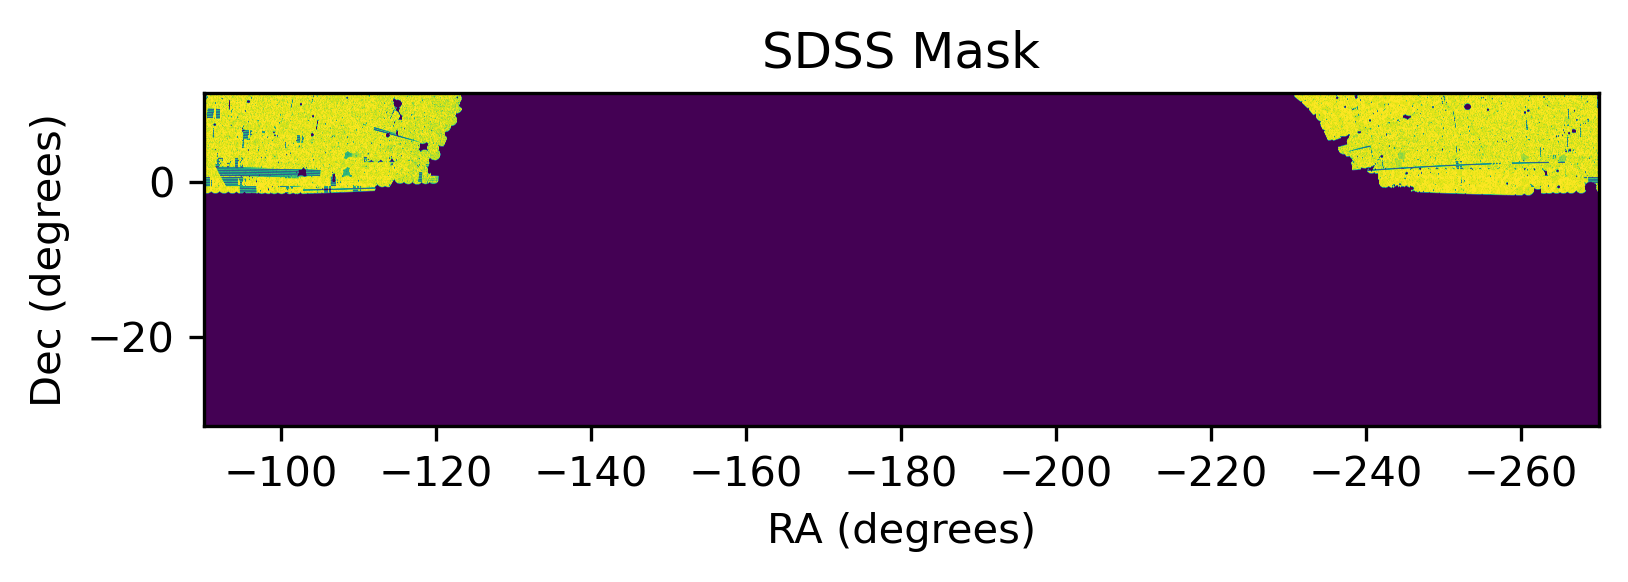

making noise power estimate
	 doing trial 1 of 1
making xfer function
	 doing trial 1 of 1


In [ ]:
# Now that we've demonstrated that the iterative fl computation works, we'll implement the new paradigm to do a 2D computation
# Here we separate the FKP + Planck mask and the SDSS mask and implement our computation in the following manner.
# $ehat \prop \sigma_{i} T_hp(\Theta_i)v_r(\vec{x}_i)$ where now $T_{hp}$ is computed as:
# T_{hp} = M_{SDSS} * sph_inv(l_weight * sph(M_{fkp} * T_{act}))
# where sph is the spherical harmonic xform and maps map -> harmonic space and sph_inv is its inverse.
# This process takes 2x spherical xforms and 2x map-space multiplications.
# If we only desire T_hp evaluated at galaxy locations we can extract the relevant entries from both the SDSS mask and
# the l-weighted, fkp-weighted CMB map and multiply these in the final step. This removes a map-sized operation and replaces it 
# with a gal-survey-sized operation.
#
# In general, this will be our convention for map-space 2D quantities; we apply the SDSS mask last to avoid edge effects

# import data and compute fl prior to SDSS mask
map_t = enmap.read_map(map_path)[0]
ivar_t = enmap.read_map(ivar_path)[0]
map_fkp_nogal = enmap.read_map(fkp_nogal_path)
mask_sdss = enmap.read_map(gal_mask_path)

# plot the SDSS mask for inspection
plot_map(mask_sdss, title='SDSS Mask', corners=map_t.corners())

act_pipe = ACTData(map_t, ivar_t, map_fkp_nogal, niter_fl=1)
act_pipe.make_xfer()

plt.figure(dpi=300)
plt.title('transfer function comparison')
plt.plot(ells[50:], act_pipe.fl[50:], label='fl')
plt.plot(ells[50:], act_pipe.fl_raw[50:], label='fl raw', alpha=0.5)
plt.legend()
plt.show()

# verify that sim and observed cls agree
act_pipe.compare_cl(label='nogal')

# import pre-determined optimal l-weight function:
cl_ksz_th = np.exp(-(ells / R_LWIDTH / 5500.)**2)
l_weight = cl_ksz_th / act_pipe.cl_act_obs # here the SDSS noise power spectrum is taken to be flat on the relevant scales
l_weight[:1500] = 0. # zero the low-l weights

plt.figure(dpi=300)
plt.title('2D pipeline l-weight')
plt.plot(ells, l_weight)
plt.xlabel(u'$l$')
plt.show()



In [ ]:
from fnl_pipe.pipe import GalPipe

NTRIAL_SIM = 3


# import the galaxy data and make the vr list at pixel locs
gal_pipe = GalPipe(catalog_path, act_pipe.map_t, diag_plots=True)
gal_pipe.import_data()
gal_pipe.make_vr_list()

mask_ones = mask_sdss.copy()
mask_ones[:,:] = 1.


processed_map = act_pipe.process_map(mask_sdss, l_weight=l_weight)
processed_map_nomask = act_pipe.process_map(mask_ones, l_weight=l_weight)
ehat_ksz = gal_pipe.compute_a_ksz(processed_map) # compute the unnormalized data estimator
ehat_ksz_nomask = gal_pipe.compute_a_ksz(processed_map_nomask)

observed_cl = map2cl(processed_map, lmax=act_pipe.lmax)
observed_cl_nomask = map2cl(processed_map_nomask, lmax=act_pipe.lmax)

ehat_samples = np.zeros(NTRIAL_SIM)
ehat_samples_nomask = np.zeros(NTRIAL_SIM)
for itrial in range(NTRIAL_SIM):
    print(f'running sim trial {itrial + 1} of {NTRIAL_SIM}...')
    sim_map = act_pipe.get_sim_map()
    mask_map = act_pipe.process_map(mask_sdss, l_weight=l_weight, map_t=sim_map)
    nomask_map = act_pipe.process_map(mask_ones, l_weight=l_weight, map_t=sim_map)
    
    if itrial == 0:
        print('doing mask/nomask cl comparison')
        mask_cl = map2cl(mask_map, lmax=act_pipe.lmax)
        nomask_cl = map2cl(mask_map, lmax=act_pipe.lmax)
        plt.figure(dpi=300)
        plt.title('mask/nomask vs observed cl comparison')
        plt.plot(ells[50:], mask_cl[50:]/observed_cl[50:], label='mask sim cl / act cl')
        plt.plot(ells[50:], nomask_cl[50:]/observed_cl_nomask[50:], label='nomask sim cl / nomask act cl')
        ax = plt.gca()
        ax.set_ylim([0,2])
        plt.xlabel(u'$l$')
        plt.legend()
        plt.show()
        
        plt.figure(dpi=300)
        plt.title('sim/act cl comparison (mask)')
        plt.plot(ells[50:], norm[50:] * mask_cl[50:], label='mask sim cl')
        plt.plot(ells[50:], norm[50:] * observed_cl[50:], label='mask act cl')
        plt.xlabel(u'$l$')
        plt.legend()
        plt.show()
        
        plt.figure(dpi=300)
        plt.title('sim/act cl comparison (nomask)')
        plt.plot(ells[50:], norm[50:] * nomask_cl[50:], label='nomask sim cl')
        plt.plot(ells[50:], norm[50:] * observed_cl_nomask[50:], label='nomask act cl')
        plt.xlabel(u'$l$')
        plt.legend()
        plt.show()
        
        
    ehat_samples[itrial] = gal_pipe.compute_a_ksz(mask_map)
    ehat_samples_nomask[itrial] = gal_pipe.compute_a_ksz(nomask_map)
    
    if itrial > 1:
        ehat_std = ehat_samples.std()
        ehat_std_nomask = ehat_samples_nomask.std()
    
print(f'sample mean/std: {ehat_samples.mean(), ehat_samples.std()}')
print(f'sample mean/std (no sdss mask): {ehat_samples_nomask.mean(), ehat_samples_nomask.std()}')
print(f'kSZ significance: {ehat_ksz/ehat_std}')
print(f'kSZ significance nomask: {ehat_ksz_nomask/ehat_std_nomask}')
